In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import astropy.coordinates as coord
import astropy.time as atime
import astropy.units as u

import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics
from dataclasses import dataclass

from jax.config import config

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/state/partition1/job-43512746/ipykernel_744360/3276749171.py:25: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
files = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/*.fits',recursive = True)

In [4]:
files

['/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:23:16.503.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:19:56.113.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:23:21.403.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-10-02T10:01:41.470.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:23:15.873.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-10-02T10:00:26.630.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-18T12:09:45.507.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-16T11:08:05.690.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-10-02T10:01:12.613.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:22:03.910.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-18T12:11:00.927.fits',
 '/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-09-17T11:22:08.643.fits',
 '/scratch/mdd42

In [5]:
hdu1 = fits.open(files[3])

In [6]:
hdu1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5010352 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = '313147D '                                                            
EXTNAME = 'SPECTRUM'           / Extension Name                                 
DATASUM = '4233192439'         / data unit checksum updated 2014-09-29T18:59:06 
TTYPE2  = 'FLUX    '        

In [7]:
wave = np.array(hdu1[1].data['WAVE'])
flux = np.array(hdu1[1].data['FLUX'])
error = np.array(hdu1[1].data['ERR'])
print(flux.shape,np.sum(np.isnan(error)),flux.shape)


(1, 313147) 313147 (1, 313147)


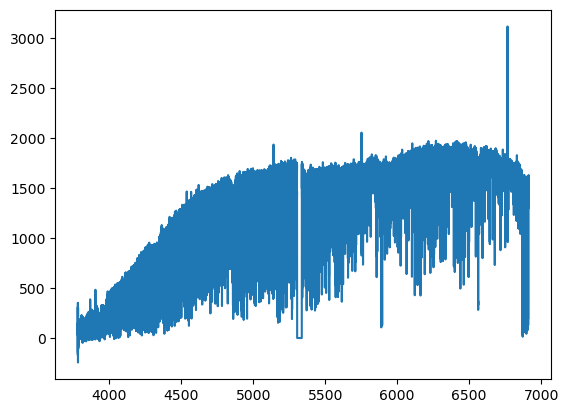

In [8]:
plt.plot(wave[0,:],flux[0,:])
plt.show()

In [9]:
xs = []
ys = []
yi = []
ma = []

mjds = []
ams = []
bcs = []
rest_vel = []

targ_rv = []

wave_min = 3000
wave_max = 8000
for file in files:
    # hdu1 = fits.open(file)
    # print(hdu[0].header['HIERARCH ESO TEL TARG RADVEL'])
    try:
        hdu1 = fits.open(file)
        # print(hdu1[0].header['SPECSYS'],': ', hdu1[0].header['HIERARCH ESO DRS BERV'])
        ams.append(np.double(hdu1[0].header['AIRMASS']))
        rest_vel.append(float(hdu1[0].header['HIERARCH ESO DRS BERV']))
        # print(rest_vel)
        wave_temp = np.array(hdu1[1].data['WAVE']).flatten()
        wave_inds = (wave_temp > wave_min) * (wave_temp < wave_max)
        ys.append(np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]))
        xs.append(np.log(wave_temp[wave_inds]))
        yi.append((np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]/np.array(hdu1[1].data['ERR']).flatten()[wave_inds])**2)
        m1 = np.array(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds] <= 0.0,dtype=bool)
        m2 = np.where(m1,1.0,np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]) < 0.0)
        ma.append((m1 + m2).astype(bool))#(np.array(hdu1[1].data['ERR']).flatten()[wave_inds] <= 0.0) + 
        mjds.append(np.double(hdu1[0].header['MJD-OBS']))

        print(hdu1[0].header['HIERARCH ESO TEL TARG RADVEL'])
        targ_rv.append(hdu1[0].header['HIERARCH ESO TEL TARG RADVEL'])
        
        # bcs.append(jabble.physics.get_star_velocity(mjds[-1],hdu1[0].header['OBJECT'],'La Silla Observatory (ESO)').to(u.m/u.s).value)
    except:
        print(file)
targ_rv = np.array(targ_rv)
rest_vel = np.array(rest_vel)*1000

/state/partition1/job-43512746/ipykernel_744360/1403474626.py:26: RuntimeWarning: divide by zero encountered in log
  ys.append(np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]))
/state/partition1/job-43512746/ipykernel_744360/1403474626.py:30: RuntimeWarning: divide by zero encountered in log
  m2 = np.where(m1,1.0,np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]) < 0.0)


-10.4
-10.4
-10.4
-10.4
-10.4


/state/partition1/job-43512746/ipykernel_744360/1403474626.py:26: RuntimeWarning: invalid value encountered in log
  ys.append(np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]))
/state/partition1/job-43512746/ipykernel_744360/1403474626.py:30: RuntimeWarning: invalid value encountered in log
  m2 = np.where(m1,1.0,np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]) < 0.0)


-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.366
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-10-06T10:04:15.680.fits
-10.4
-10.4
-10.4
-10.366
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
/scratch/mdd423/wobble_jax/data/HD4307_harps/ADP.2014-10-06T10:07:44.637.fits
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4
-10.4


In [10]:
targ_rv

array([-10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.366,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.366,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  , -10.4  ,
       -10.4  , -10.4  ])

In [11]:
ys[0]

array([ 7.507403,  7.440267,  7.196978, ..., 10.308915, 10.30255 ,
       10.312972], dtype=float32)

In [12]:
for m,y in zip(ma,ys):
    y[m] = 0.0

In [13]:
print([np.sum((np.isnan(y[~m]))) for m,y in zip(ma,ys)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
print([np.sum(y[~m] < 0) for m,y in zip(ma,ys)])
print([(x.shape == y.shape) for x,y in zip(xs,ys)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [15]:
out_dir

'../out/24-02-29'

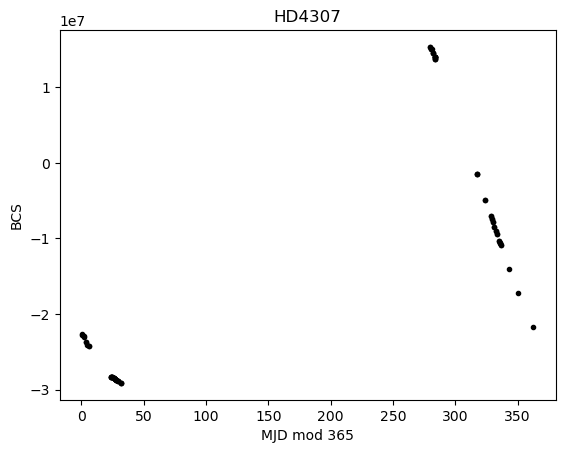

In [16]:
year = u.year.to(u.day)
plt.plot([mjd%year for mjd in mjds],np.array(rest_vel)*1000,'.k')
# plt.plot([mjd%year for mjd in mjds],jabble.physics.velocities(norm_models[0][2][0].p),'.k')
plt.title('HD4307')
plt.ylabel('BCS')
plt.xlabel('MJD mod 365')
plt.savefig(os.path.join(out_dir,'05-HD4307-rv-mjd.png'))
plt.show()

In [17]:
hdu1[0].header['HIERARCH ESO TEL TARG RADVEL']

-10.4

In [21]:
hdu1[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATASUM = '0       '           / data unit checksum updated 2014-09-13T00:04:29 
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   
DATE    = '2010-09-10T10:26:49.406' / Date this file was written                
INSTRUME= 'HARPS   '           / Instrument used                                
RA      =            11.371010 / 00:45:29.0 RA (J2000) pointing                 
DEC     =            -12.87903 / -12:52:44.5 DEC (J2000) pointing               
EQUINOX =                2000. / Standard FK5 (years)                           
RADECSYS= 'FK5     '        

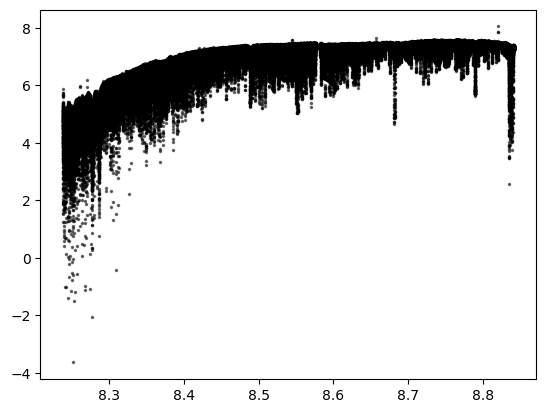

In [17]:
plt.plot(xs[3],ys[3],'.k',zorder=1,alpha=0.5,ms=3)

In [18]:
@dataclass
class Data:
    """Temporary Data Type"""
    dataframes: list

    def __getitem__(self,i):
        return self.dataframes[i]

    @property
    def yerr(self):
        return 1/np.sqrt(self.yivar)

    @property
    def xs(self):
        return [dataframe.xs for dataframe in self.dataframes]

    @property
    def ys(self):
        return [dataframe.ys for dataframe in self.dataframes]

    @property
    def yivar(self):
        return [dataframe.yivar for dataframe in self.dataframes]

    @property
    def mask(self):
        return [dataframe.mask for dataframe in self.dataframes]

    def __len__(self):
        return len(self.dataframes)

    def from_lists(xs,ys,yivar,ma):
        frames = []
        for iii in range(len(xs)):
            frames.append(DataFrame(xs[iii],ys[iii],yivar[iii],ma[iii]))
        return Data(frames)

@dataclass
class DataFrame:
    xs: jnp.array
    ys: jnp.array
    yivar: jnp.array
    mask: jnp.array


class MyChiSquare(jabble.loss.ChiSquare):
    def loss_all(self,p,data,model,*args):

        # output = jnp.zeros(len(data))
        # max_len = max([len(xs) for xs in data.xs])
        # def _padding(arr_list):
        #     arr_padded = jnp.array([jnp.pad(arr,max_len - len(arr),constant_values=0) for arr in arr_list])
        #     return arr_padded
            
        # xs_padded, ys_padded, yivar_padded, mask_padded = _padding(data.xs),_padding(data.ys),_padding(data.yivar),_padding(data.mask)

        # print(xs_padded.shape)
        # def _internal(xs,ys,yivar,mask,ind):
        #     return self(p,xs,ys,yivar,mask,ind,model,*args)
        # inds = jnp.arange(len(data))
        # output = jax.vmap(_internal,in_axes=(0,0,0,0,0),out_axes=0)(xs_padded, ys_padded, yivar_padded, mask_padded,inds)
        # return jnp.sum(output)

        output = 0.0

        for ind,dataframe in enumerate(data):

            output += self(p,dataframe,ind,model,*args).sum()
        
        return output

    def __call__(self, p, dataframe, i, model, *args):
        err = self.coefficient * jnp.where(~dataframe.mask,(((dataframe.ys - model(p,dataframe.xs,i,*args))**2)),0.0)
        return err

4056


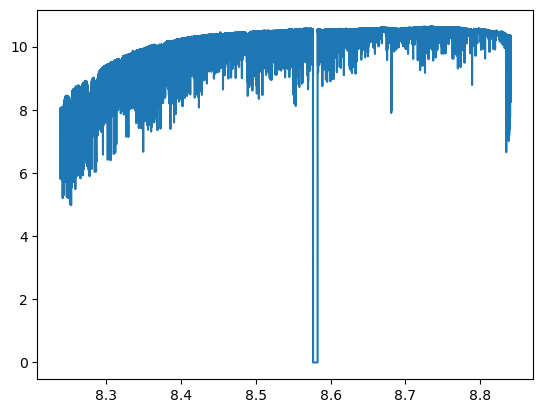

4056


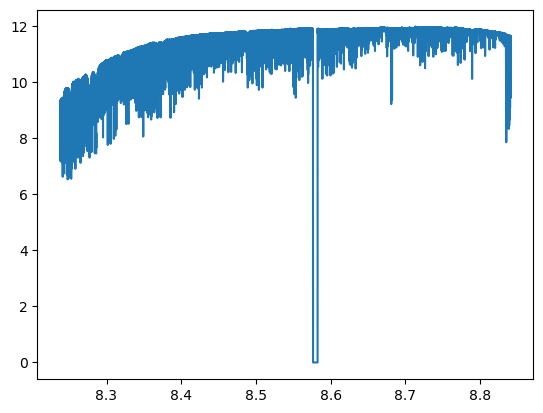

4056


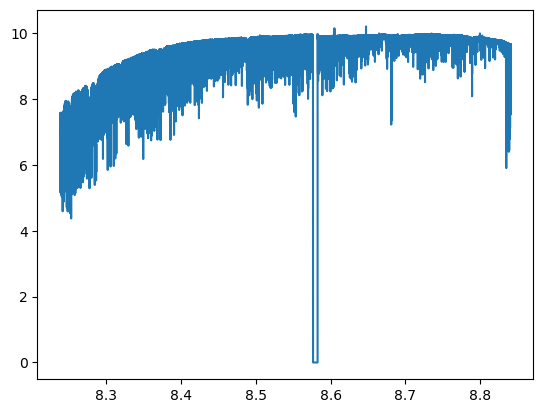

4056


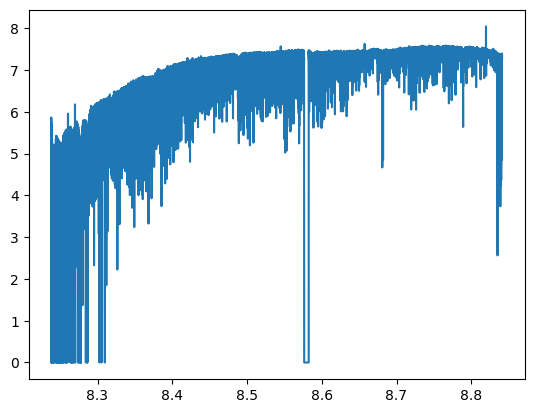

4056


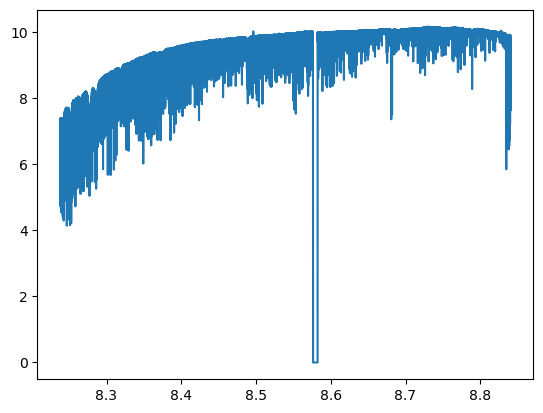

4056


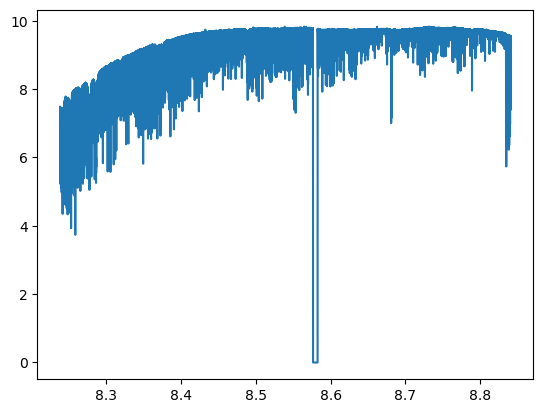

4056


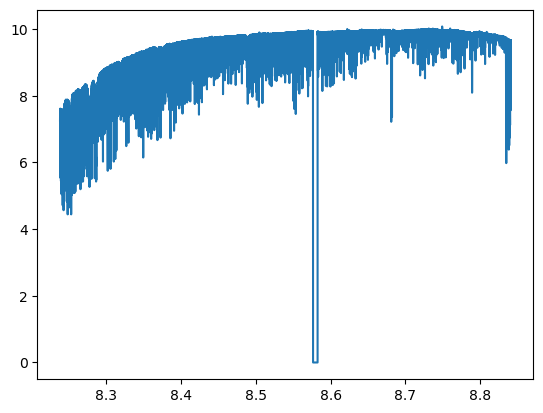

4056


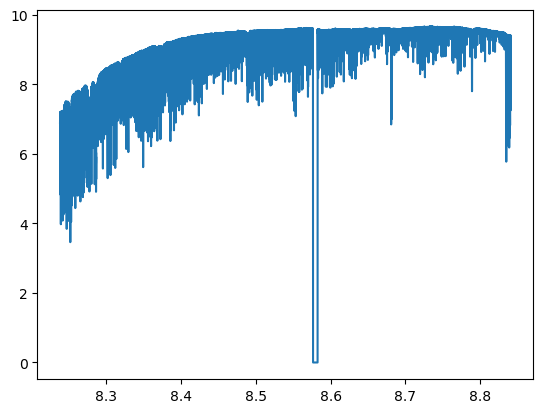

4056


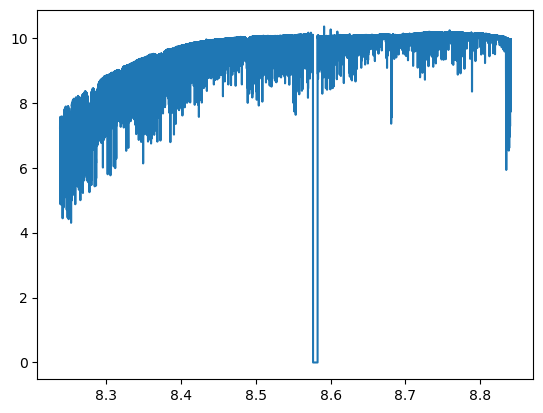

4056


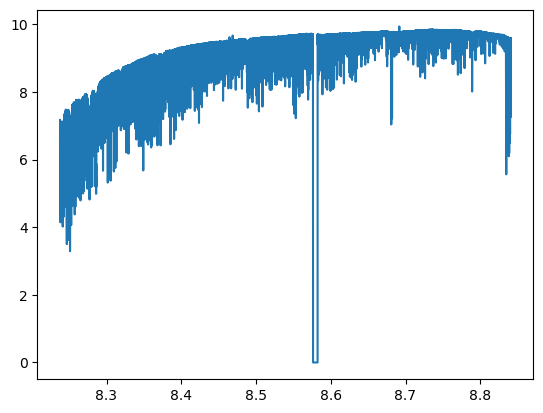

4056


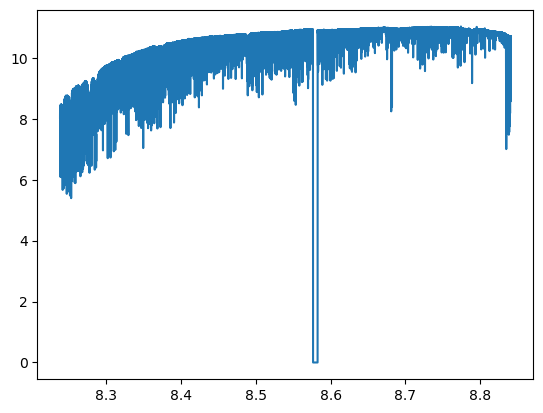

4056


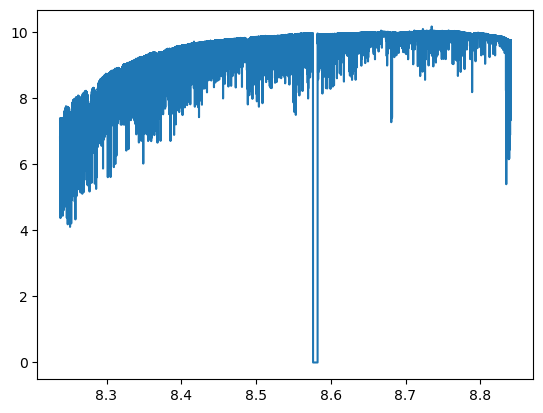

4056


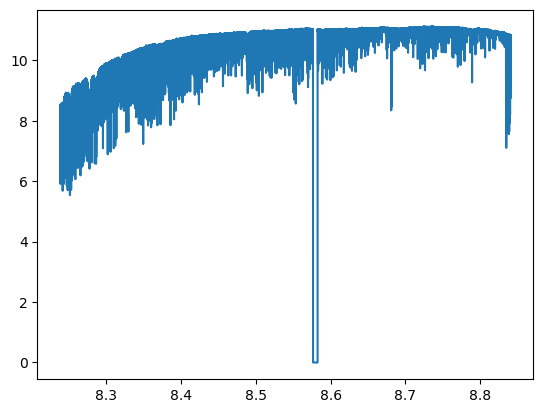

4056


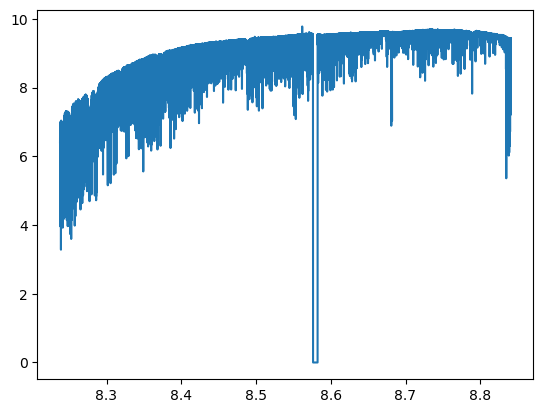

4056


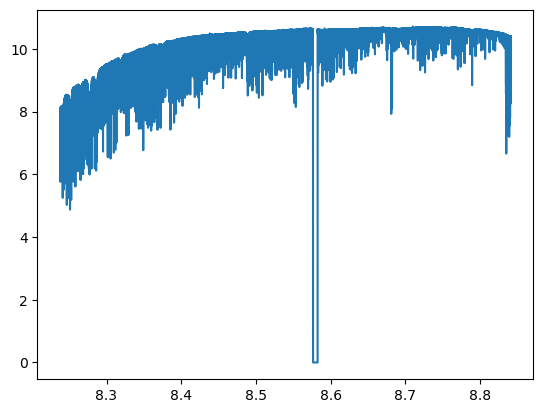

4056


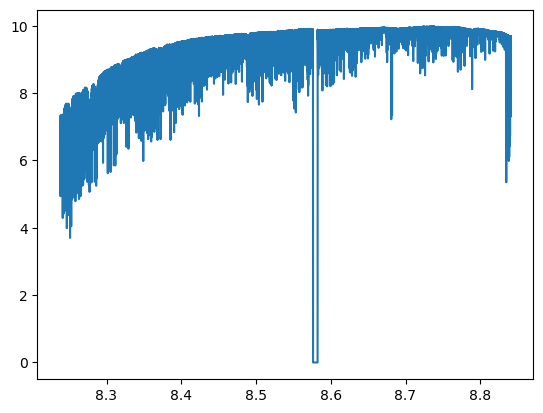

4056


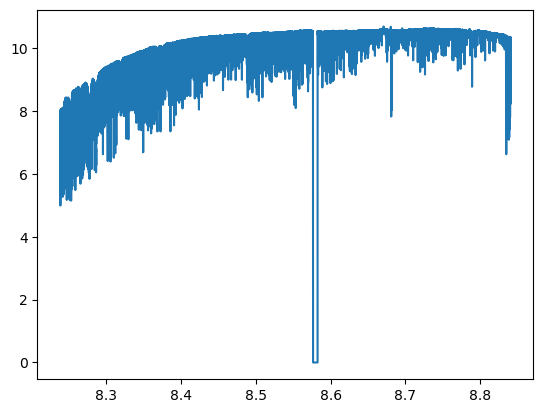

4056


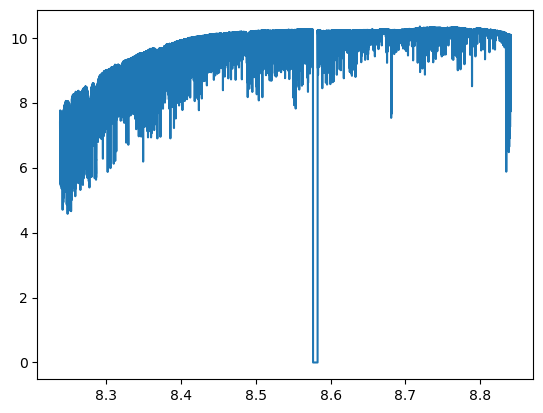

4056


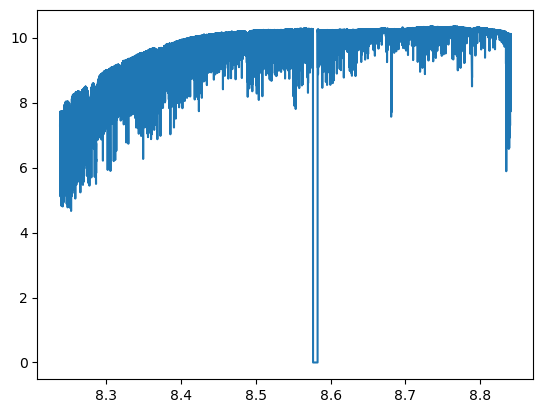

4056


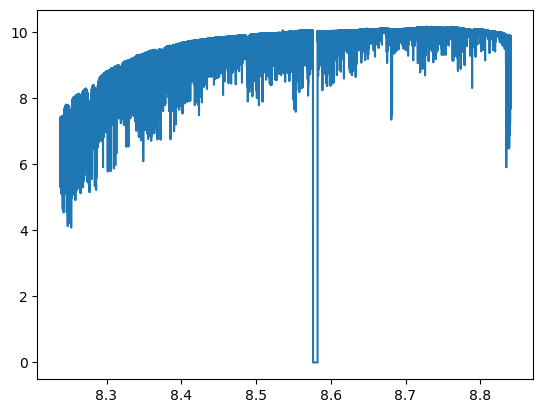

4056


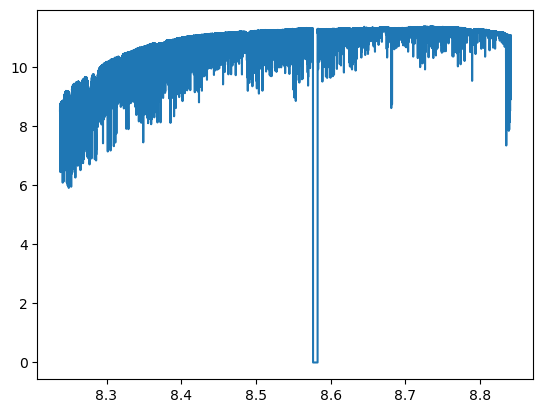

4056


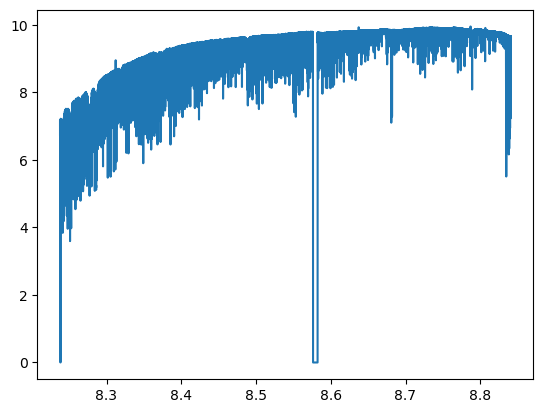

4056


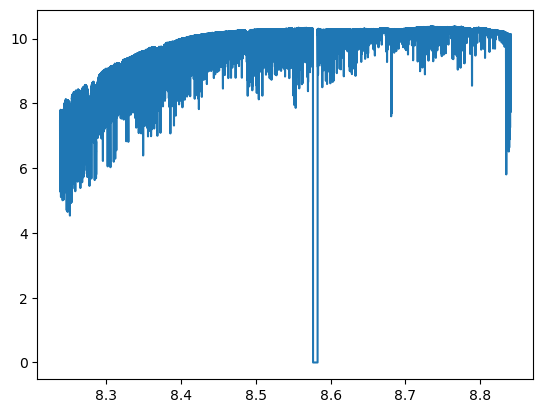

4056


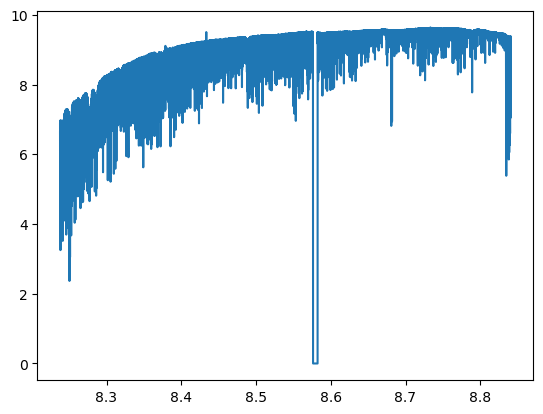

4056


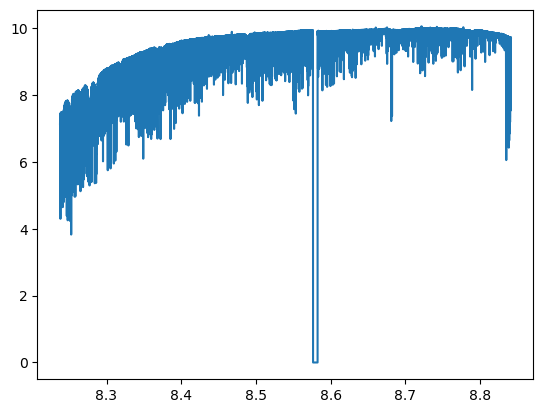

4056


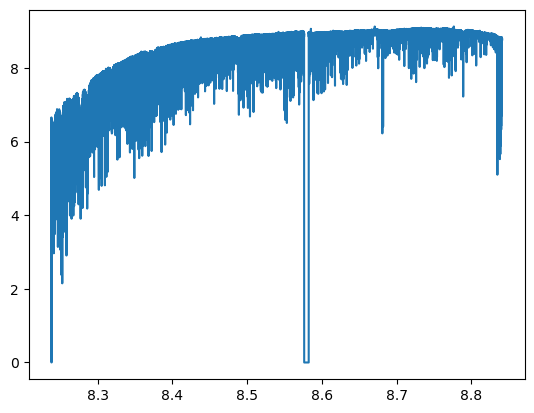

4056


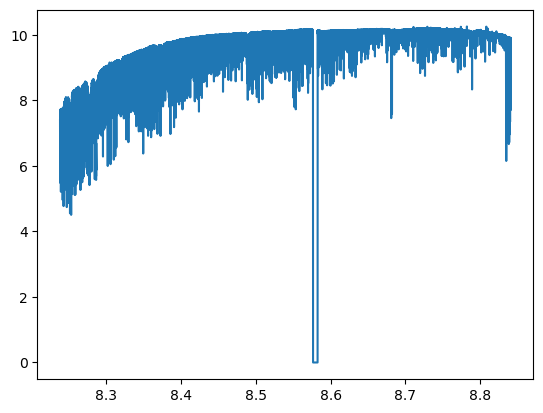

4056


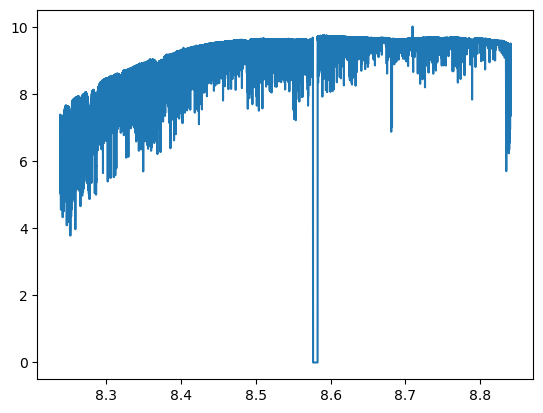

4056


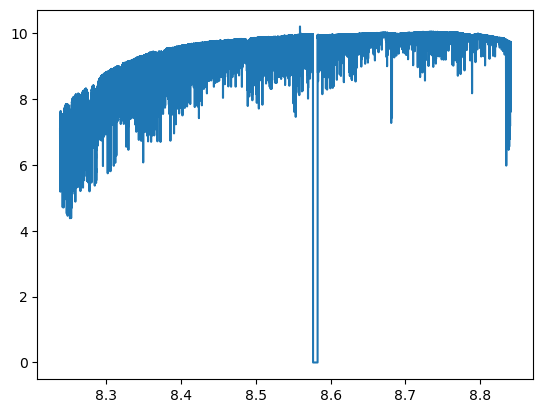

4056


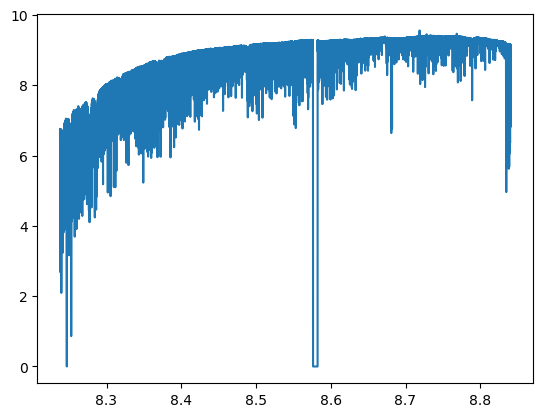

4056


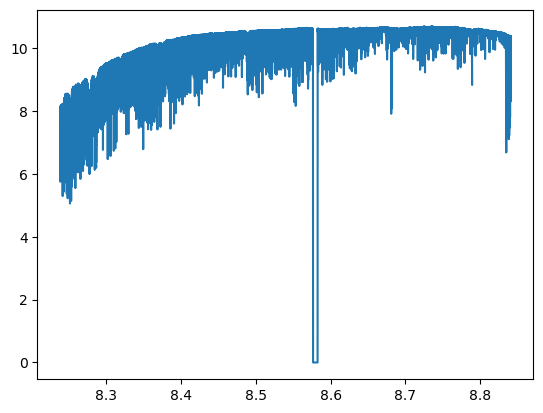

4056


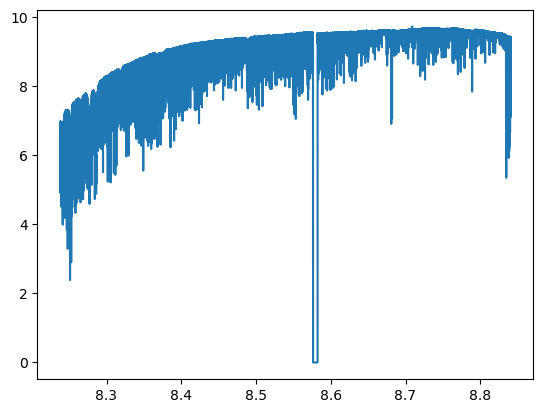

4056


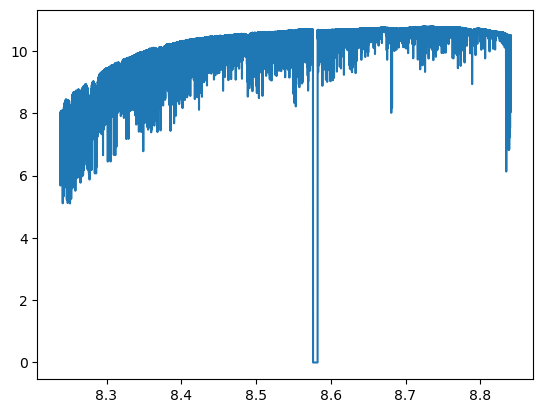

4056


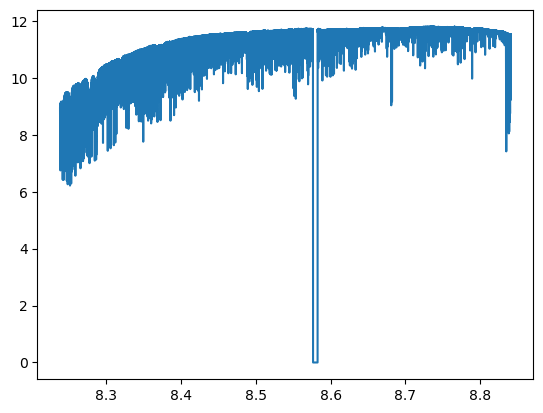

4056


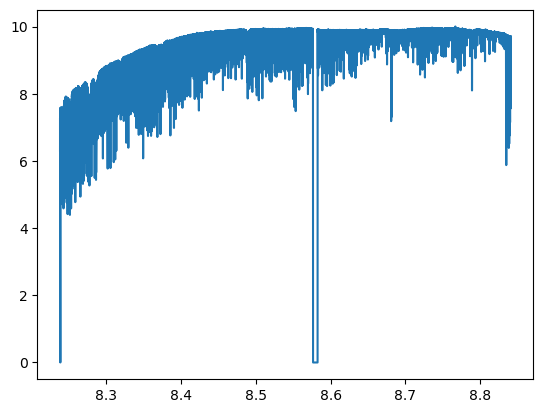

4056


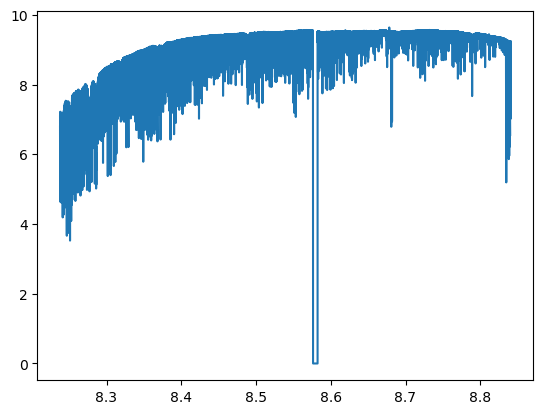

4056


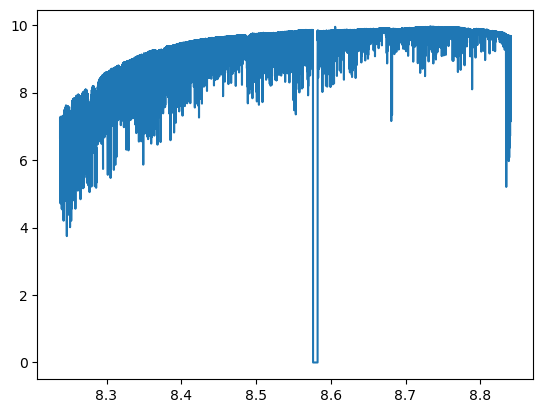

4056


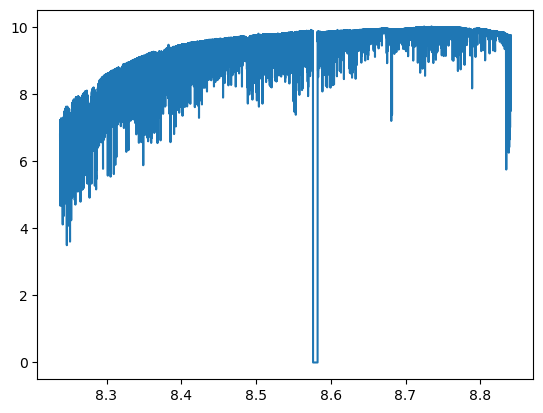

4056


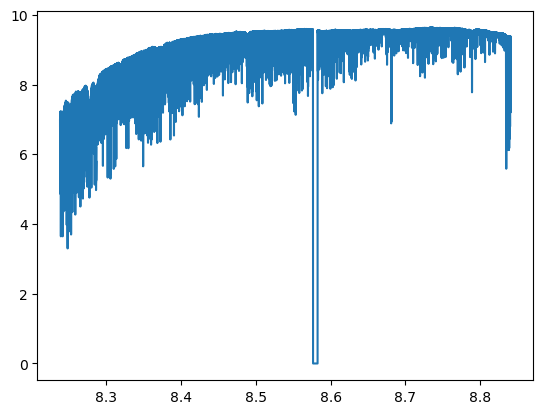

4056


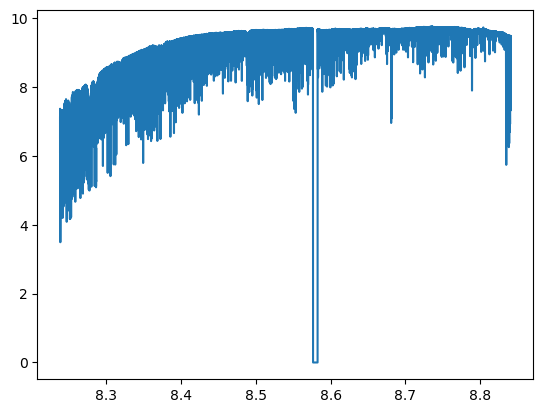

4056


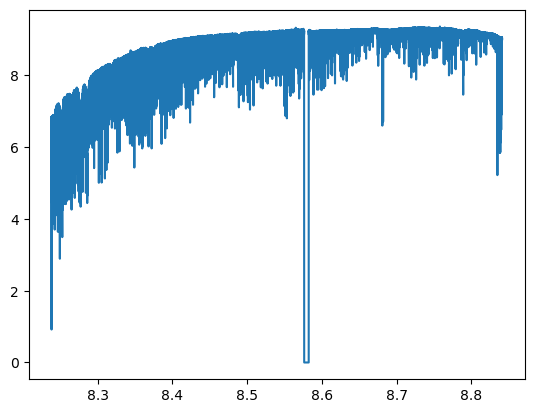

4056


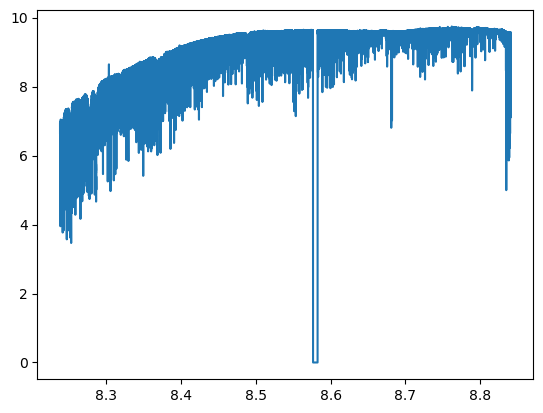

4056


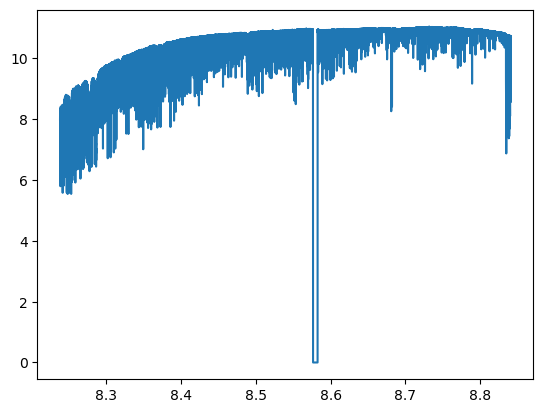

4056


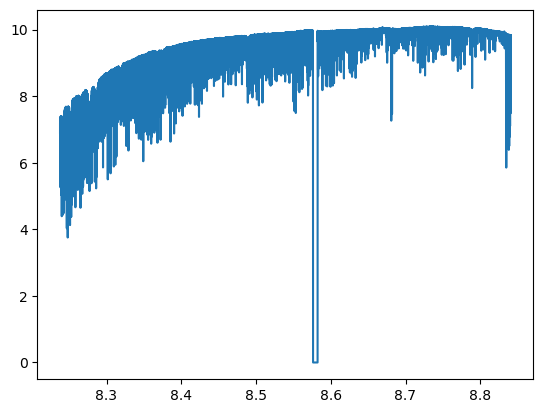

4056


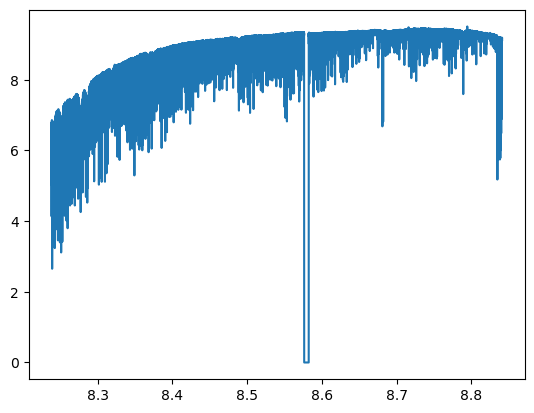

4056


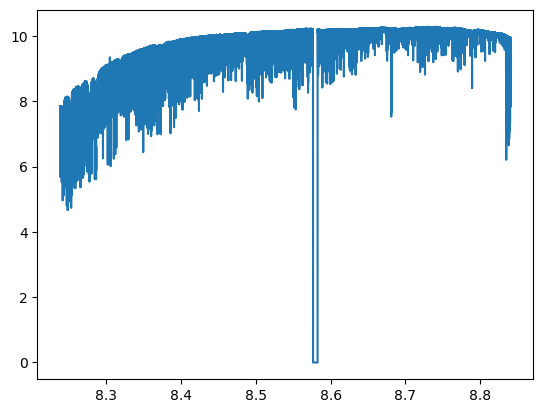

4056


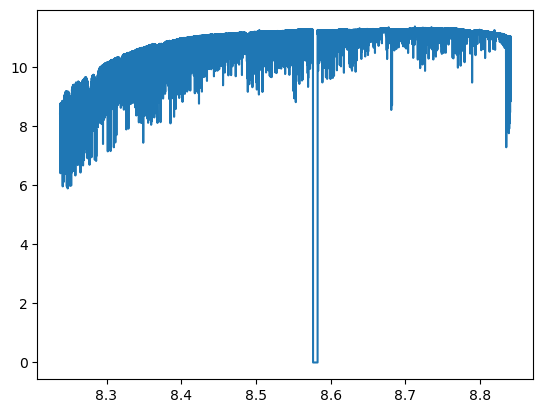

4056


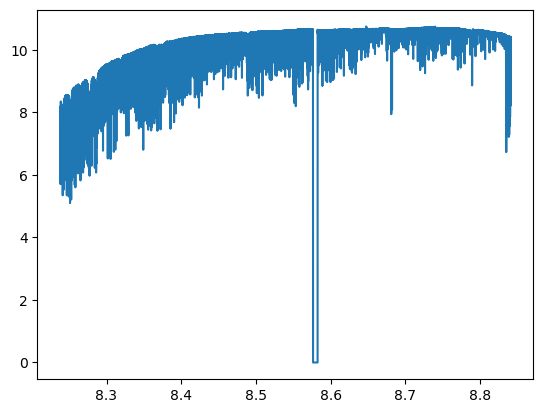

4056


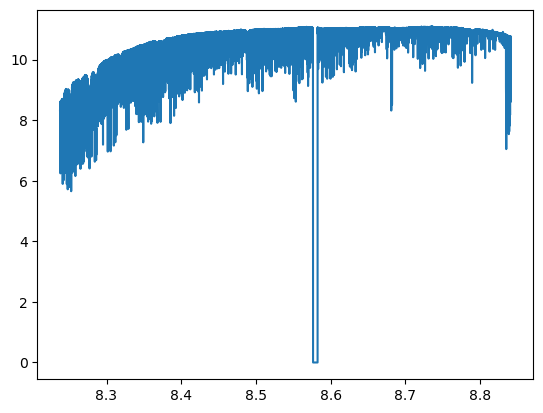

4056


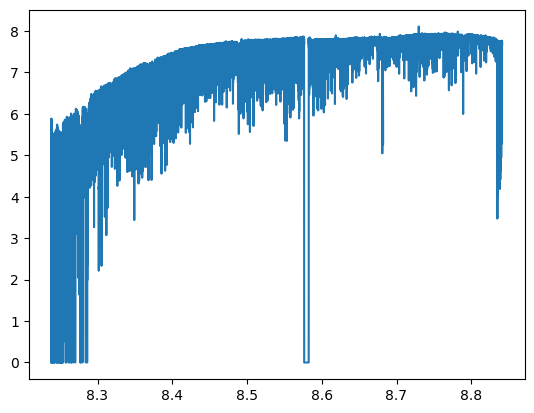

4056


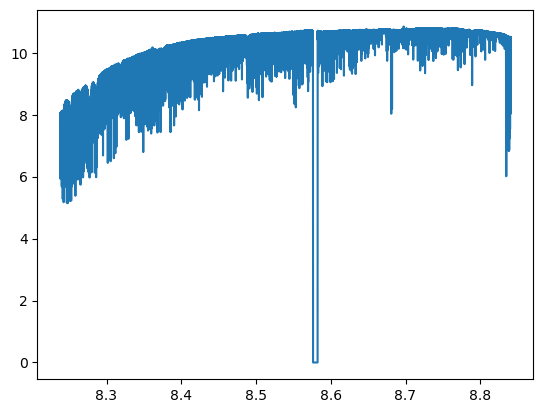

4056


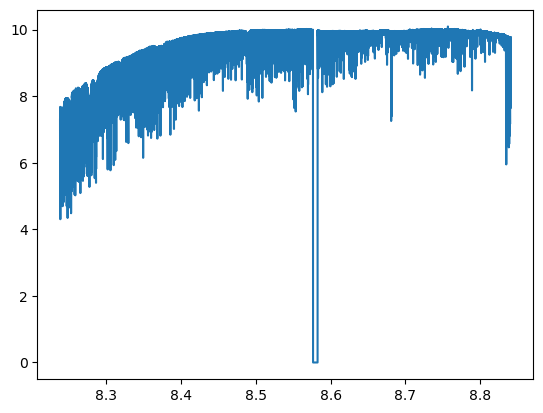

4056


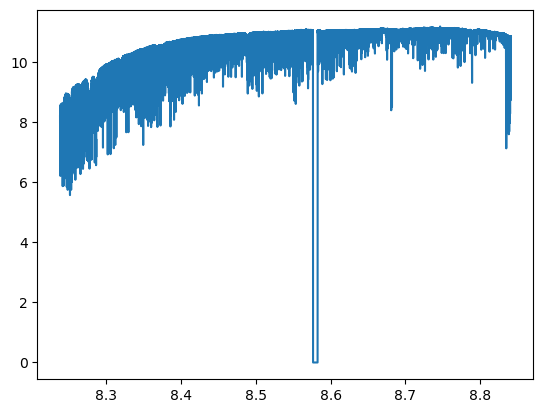

4056


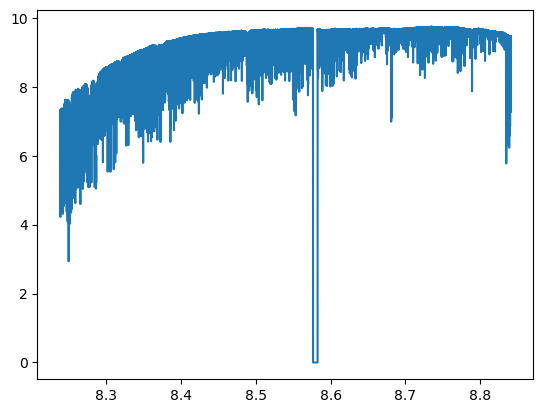

4056


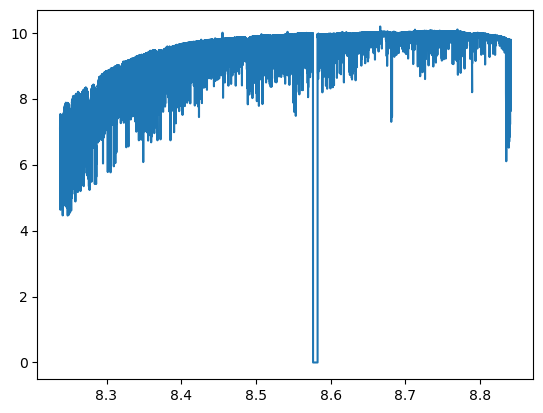

4056


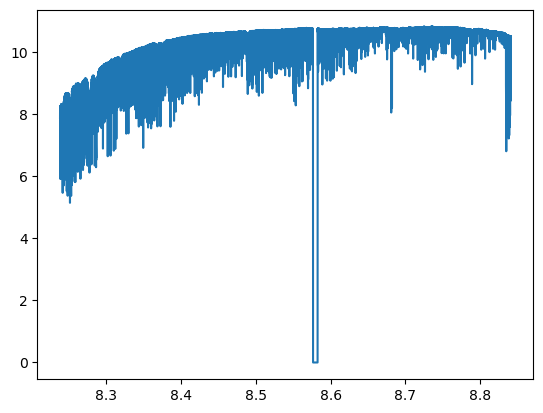

4056


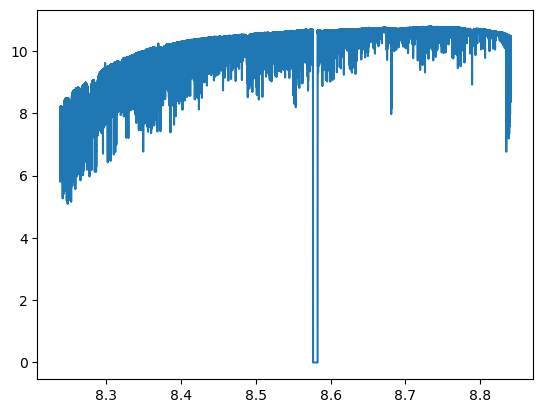

4056


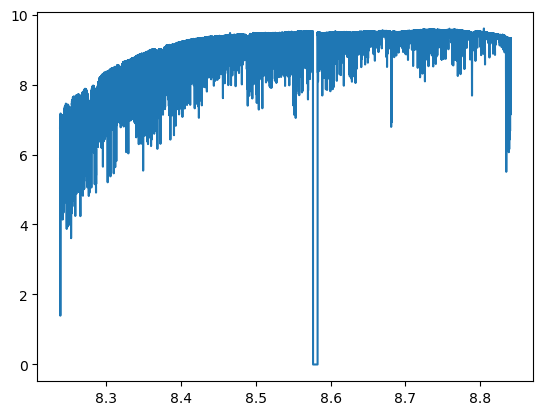

4056


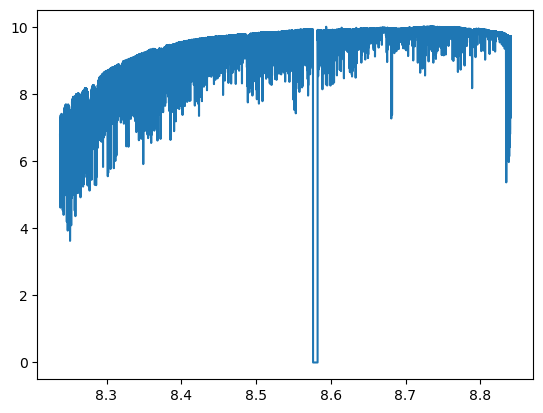

4056


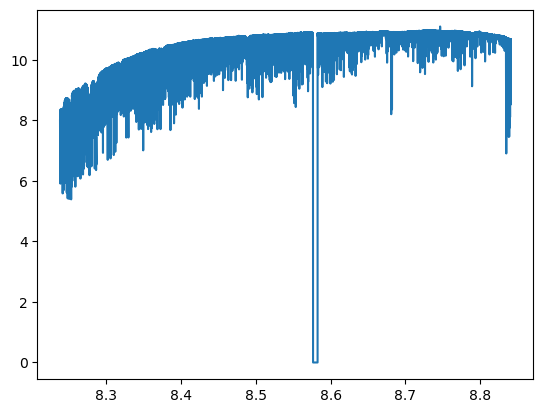

4056


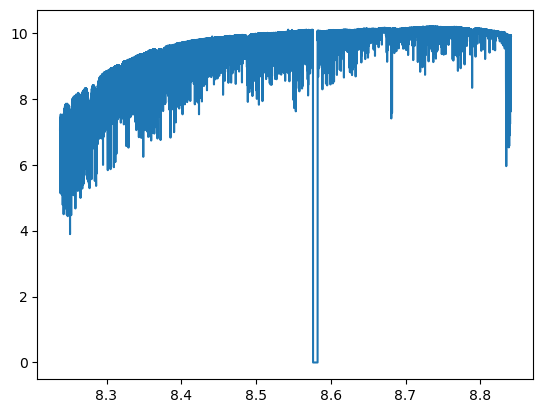

4056


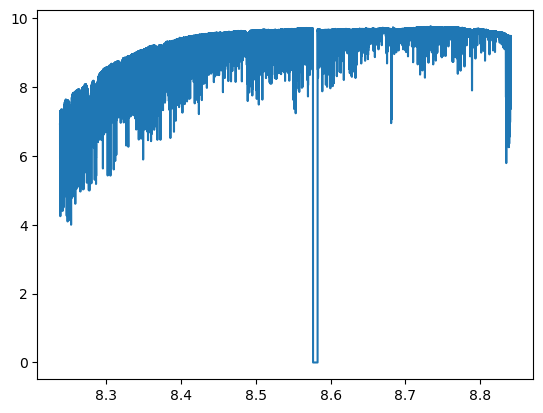

4056


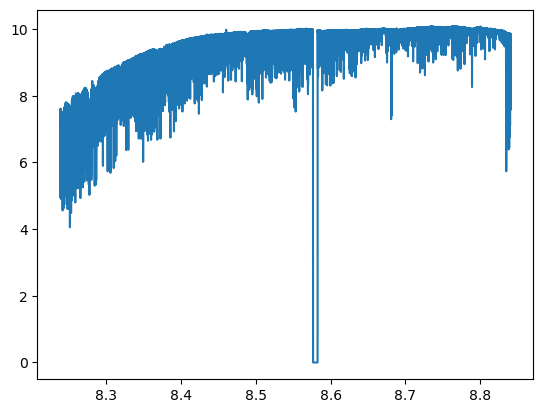

4056


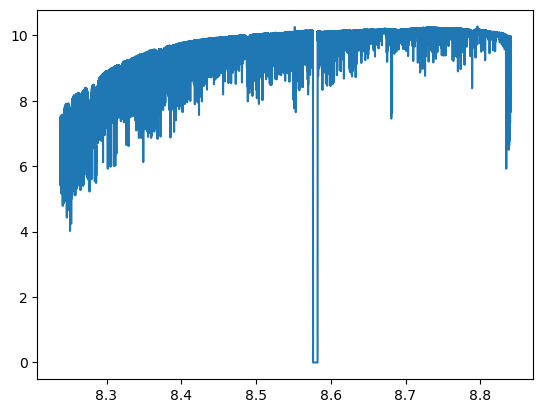

4056


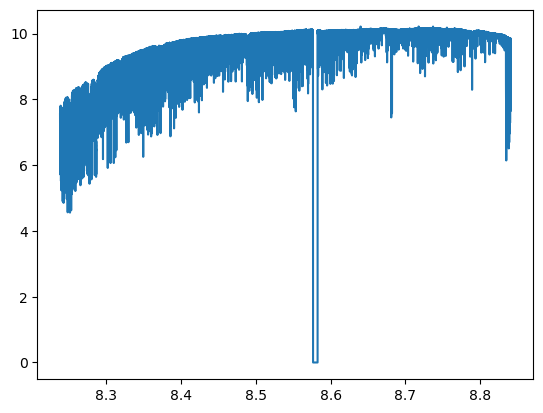

4056


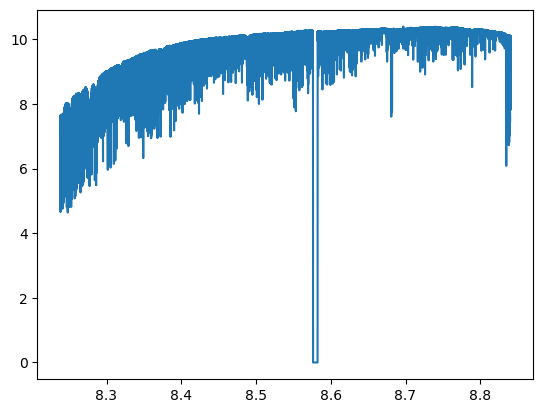

4056


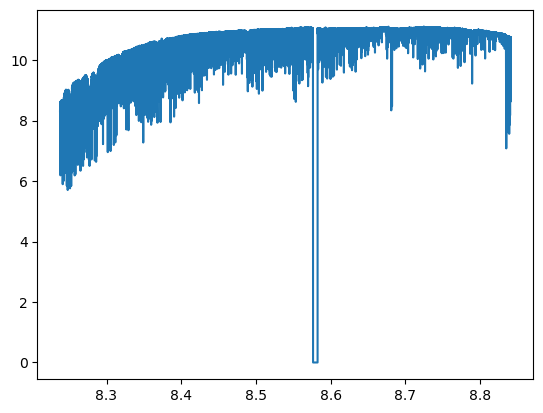

4056


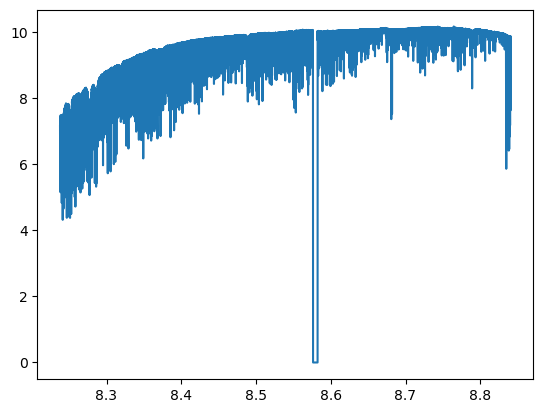

4056


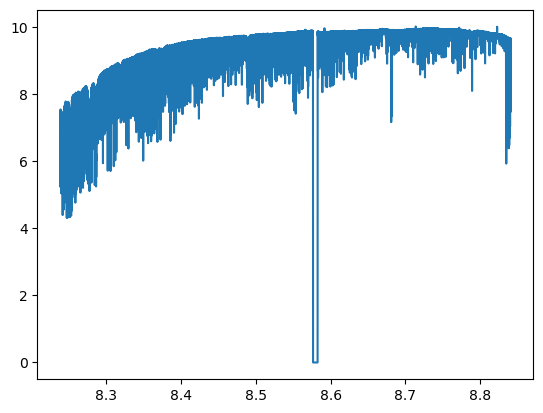

4056


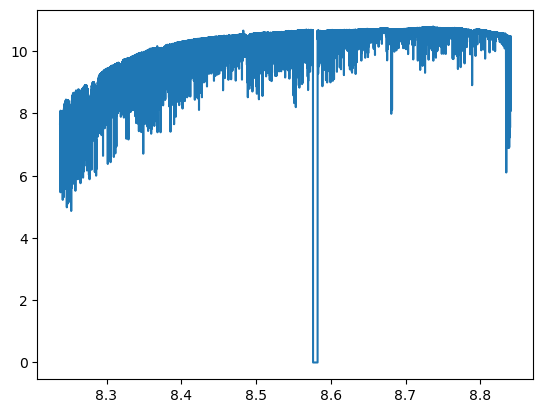

4056


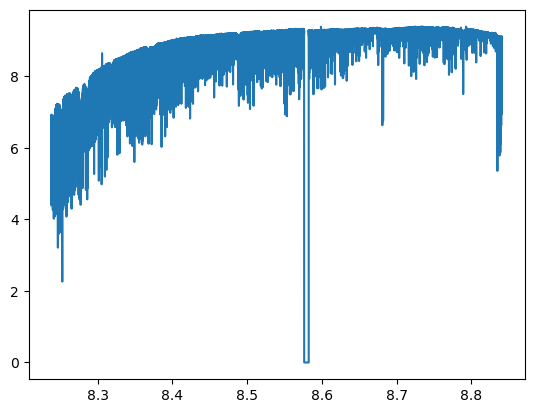

4056


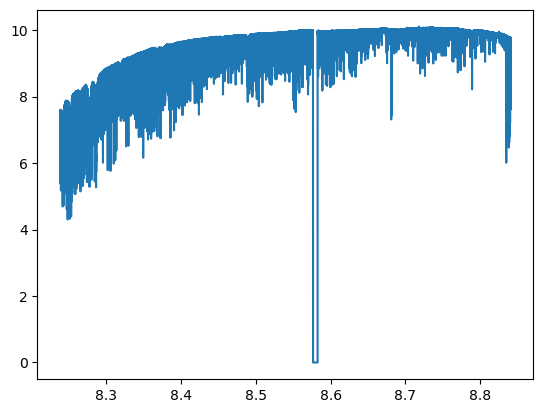

4056


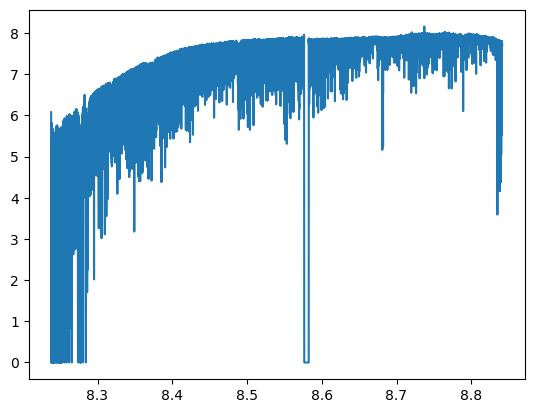

4056


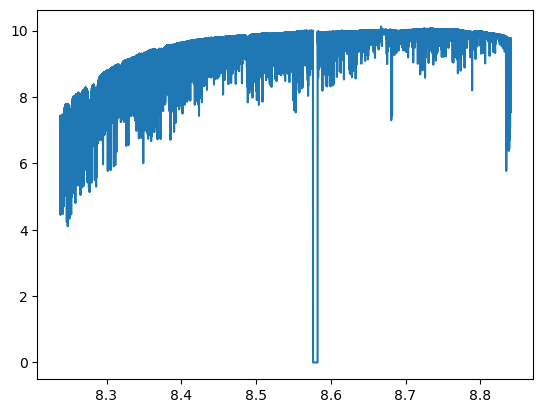

4056


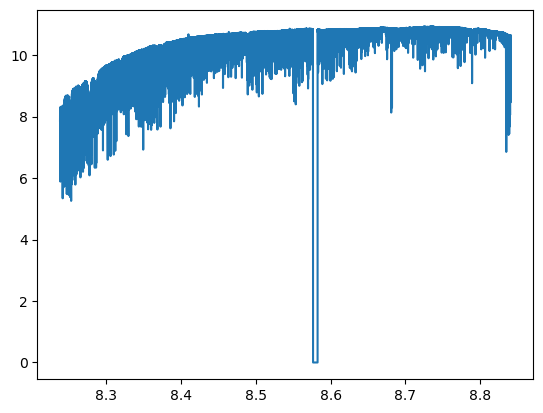

4056


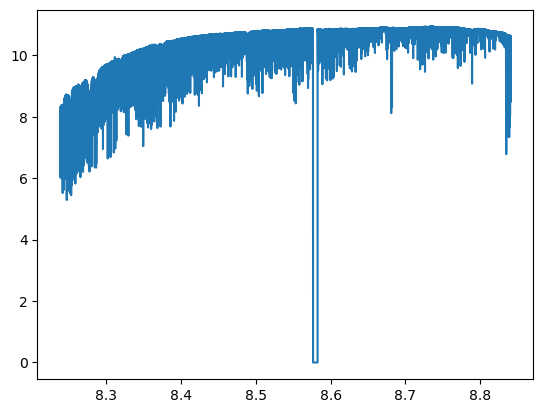

4056


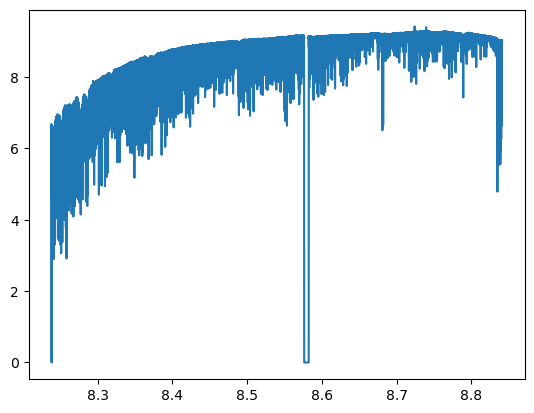

4056


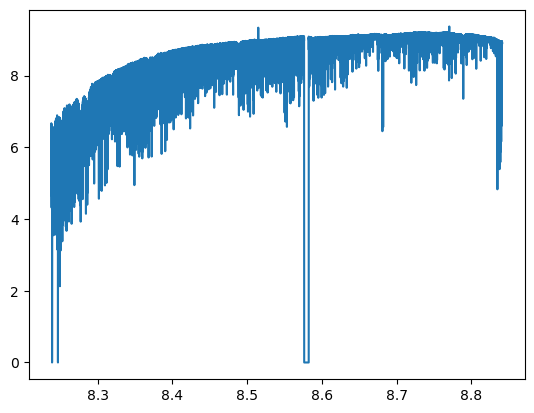

4056


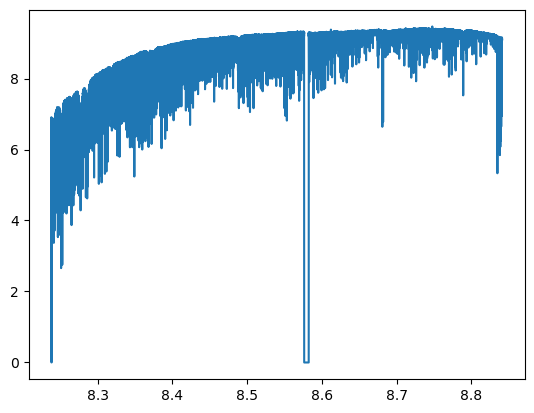

In [29]:
model.fix()
model.fit(0)
# model.display()
for i,dataframe in enumerate(data):
    
    def _internal(p):
        return loss(p,dataframe,i,model).sum()
    gradient = jax.grad(_internal)(model.get_parameters())
    nan_grad = np.isnan(gradient)
    zer_grad = np.isclose(gradient,0.0)
    # so none of the nans are coming from other epochs
    print(np.sum(zer_grad))
    # if np.sum(nan_grad) != 0:
    nan_grad_temp = model[0].split_p(nan_grad)
    # print(nan_grad_temp)
    plt.plot(dataframe.xs,dataframe.ys)
    plt.plot(model[0][i].xs[nan_grad_temp[i]],model(model.get_parameters(),model[0][i].xs[nan_grad_temp[i]],i),'.r')
    
    plt.savefig(os.path.join(out_dir, 'HD4307_nangrad_norm_{}.png'.format(i)))
    plt.show()

In [24]:
gpus = jax.devices("gpu")
xs_gpu = [jax.device_put(jnp.array(x),gpus[0]) for x in xs]
ys_gpu = [jax.device_put(jnp.array(x),gpus[0]) for x in ys]
yi_gpu = [jax.device_put(jnp.ones(x.shape),gpus[0]) for x in yi]
ma_gpu = [jax.device_put(jnp.array(x),gpus[0]) for x in ma]
data = Data([DataFrame(x1,x2,x3,x4) for x1,x2,x3,x4 in zip(xs_gpu,ys_gpu,yi_gpu,ma_gpu)])

In [25]:
data[0].xs.devices()

{cuda(id=0)}

In [26]:
data = Data.from_lists(xs,ys,yi,ma)
loss = MyChiSquare()

In [27]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,rest_shifts,airmass):
    # dx = jabble.physics.delta_x(2 * resolution)
    # x_grid = np.arange(np.min(xs), np.max(xs), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        np.concatenate([dataframe.xs for dataframe in data]), vel_padding, 2 * resolution
    )  

    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts),
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts),   
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    )
    
    return model

def get_norm_model(pts_per_wavelength,norm_p_val,p_val,data,resolution,vel_padding,init_shifts,rest_shifts,airmass):
    # xs = np.concatenate(data.xs)
    model_list = [jabble.model.IrwinHallModel_vmap(\
        np.linspace(np.min(dataframe.xs),np.max(dataframe.xs),\
                    int((np.exp(np.max(dataframe.xs)) - np.exp((np.min(dataframe.xs)))) * pts_per_wavelength)\
                   ), norm_p_val) for dataframe in data]
    norm_model = jabble.model.NormalizationModel(model_list) + get_model(data,resolution,p_val,vel_padding,init_shifts,rest_shifts,np.array(airmass))
    return norm_model

In [28]:
norm_p_val = 2
p_val = 3
resolution = 120_000

init_shifts = np.zeros(len(rest_vel))
rest_shifts = jabble.physics.shifts(rest_vel)
vel_padding = 60_000

norm_pt = 1/60
model = get_norm_model(norm_pt,norm_p_val,\
                      p_val,data,resolution,vel_padding,\
                      init_shifts,rest_shifts,ams) 

In [30]:
model.to_device(gpus[0])
init_shifts.shape,(model[2][1].p.shape)

((79,), (144917,))

In [31]:
model.fit()
model.display()

-AdditiveModel------------------------------------------------294179
  0-NormalizationModel------------------------------------------4108
  0  0-IrwinHallModel_vmap----------------------------------------52
  0  1-IrwinHallModel_vmap----------------------------------------52
  0  2-IrwinHallModel_vmap----------------------------------------52
  0  3-IrwinHallModel_vmap----------------------------------------52
  0  4-IrwinHallModel_vmap----------------------------------------52
  0  5-IrwinHallModel_vmap----------------------------------------52
  0  6-IrwinHallModel_vmap----------------------------------------52
  0  7-IrwinHallModel_vmap----------------------------------------52
  0  8-IrwinHallModel_vmap----------------------------------------52
  0  9-IrwinHallModel_vmap----------------------------------------52
  0  10-IrwinHallModel_vmap---------------------------------------52
  0  11-IrwinHallModel_vmap---------------------------------------52
  0  12-IrwinHallModel_vmap-------

In [32]:
def fit_cycle(model,loss,data):
    # Fit Norm
    model.fix()
    model.fit(0)
    res = model.optimize(loss, data)
    print(res)
    print(np.sum(np.isnan(res['grad'])))
    # Fit Stellar
    model.fix()
    model.fit(1,1)
    res = model.optimize(loss, data)
    print(res)
    # Fit Stellar, Tellurics
    model.fix()
    model.fit(2,1)
    model.fit(1,1)

    inds = model.get_indices(2)
    loss_regged = loss#MyLossSeq([loss,jabble.loss.L2Reg(indices=inds)])
    res = model.optimize(loss_regged, data)
    print(res)
    # Fit RVs
    model.fix()
    model.fit(1,0)
    res = model.optimize(loss, data)
    print(res)
    # Fit Everything
    model.fix()
    model.fit(0)
    model.fit(1,0)
    model.fit(1,1)
    model.fit(2,1)

    inds = model.get_indices(2)
    loss_regged = loss#MyLossSeq([loss,jabble.loss.L2Reg(indices=inds)])
    res = model.optimize(loss_regged, data)
    print(res)
    return model

In [33]:
len(data.xs),len(init_shifts),len(data.ys)

(79, 79, 79)

In [34]:
import cProfile

In [35]:
statsname = 'hd4307stats.stat'
cProfile.run('fit_cycle(model,loss,data)',statsname)

{'grad': array([-0.18206341,  0.27303924,  0.01020599, ...,  0.1102864 ,
        0.06893568,  0.25889532]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 43, 'nit': 21, 'warnflag': 0}
0
{'grad': array([0., 0., 0., ..., 0., 0., 0.]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 152, 'nit': 146, 'warnflag': 0}
{'grad': array([0., 0., 0., ..., 0., 0., 0.]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 150, 'nit': 144, 'warnflag': 0}
{'grad': array([-2.59844983,  0.72465385, -0.40412258, -3.22461572, -3.42348305,
       -0.31935572,  0.08042382,  6.97470878,  0.25822261, -0.02257802,
        1.38583402,  7.53782893,  3.200603  ,  5.08659394, -0.81078888,
        4.22967519, -1.53759431,  1.3707058 ,  2.57244396, -0.00899709,
       -1.00313008,  0.26771396,  4.56943038, -2.98809357,  1.60792769,
        5.10856041, -0.08159498, -0.20378674,  0.55459934, -1.63168262,
       -5.54127634,  0.07748649, -0.86552341,  0

In [36]:
mdl_name = 'hd4307_l{}-{}'.format(wave_min,wave_max)
jabble.model.save('{}.mdl'.format(mdl_name),model)

In [98]:
def make_norm_plot(model,dataset,plt_epoches,lmin,lmax,lrange,plt_name,bcs):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex=True,sharey='row',facecolor=(1, 1, 1),dpi=200)
        
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin),np.log(lmax),dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[0]([],xplot,plt_epoch)
        yplot_norm_stel = model[1]([],xplot,plt_epoch)
        yplot_norm_tell = model[2]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())

        velocity = jabble.physics.velocities(model[1][0].p[plt_epoch])
        axes[0,ii].set_title('RV: {:2.1e}, $\delta\lambda$: {:2.1e}, BERV: {:2.1e}'.format(velocity,model[1][0].p[plt_epoch] * np.mean(lrange),bcs[plt_epoch]),fontsize=10)
        
        
    
        # Data
        axes[0,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                                 '.k',zorder=1,alpha=0.1,ms=3)
        axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 '.k',zorder=1,alpha=0.1,ms=3)

        # Norm Model
        axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        # axes[0,ii].set_ylim(-2+np.mean(yplot),0.1+np.mean(yplot))
        # print(np.mean(yplot))
        

        # Stellar Model        
        axes[1,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Telluric Model
        axes[1,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        

        # Residuals
        res_ax = axes[1,ii].twinx()
        res_ax.step(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),\
                                 '.b',zorder=1,alpha=0.1,ms=3)
        align.yaxes(
            axes[1,ii], -2.0, res_ax, 0.0, 0.5
        )
        axes[1,ii].set_ylim(-2,0.1)
        res_ax.set_ylim(-0.2,0.2)
        axes[0,ii].set_xticks([])
        axes[1,ii].set_xticks(np.log(lrange))
        axes[1,ii].set_xticklabels(['{}'.format(x) for x in lrange])
        # axes[0,ii].set_ylims()
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        # line_lamb = np.log(6563)
        # axes[1,ii].axvline(line_lamb)
        # axes[0,ii].axvline(line_lamb)

    fig.text(0.5, 0.04, 'Wavelength ($\AA$)', ha='center')
    plt.savefig(plt_name,dpi=300,bbox_inches='tight')
    #plt.show()

In [99]:
index_sort = np.argsort(rest_vel)

In [100]:
len(rest_vel)

79

In [101]:
from mpl_axes_aligner import align

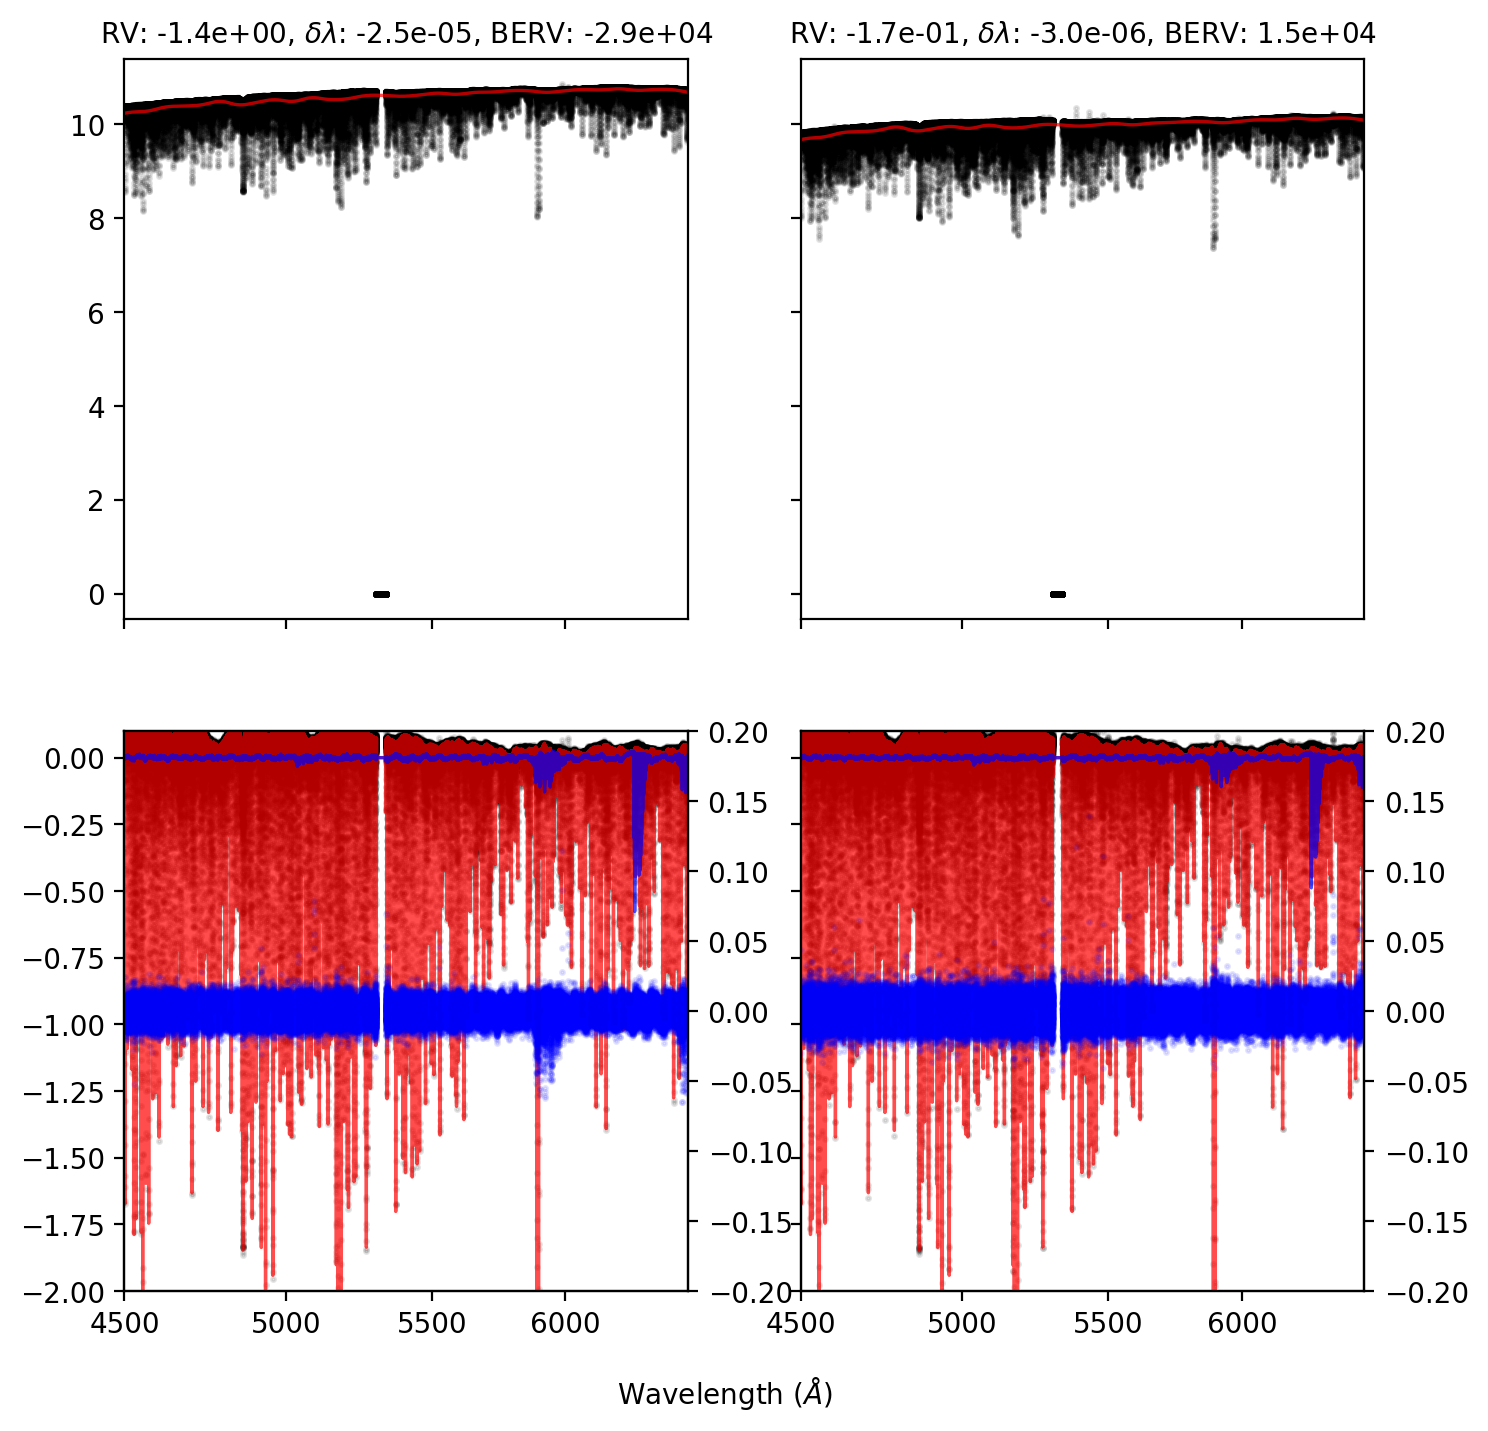

In [102]:
plt_epoches= [*index_sort[:1],*index_sort[-1:]]
lmin = 4500
lmax = 6500
lrange = np.arange(lmin,lmax,500)
plt_name = os.path.join(out_dir,'05-{}_r{}-{}_e{}.png'.format(mdl_name,np.min(lrange),np.max(lrange),plt_epoches))
make_norm_plot(model,data,plt_epoches,lmin,lmax,lrange,plt_name,rest_vel)

In [ ]:
9999*196

In [ ]:
import pstats
from pstats import SortKey

In [ ]:
p = pstats.Stats(statsname)
p.sort_stats(SortKey.TIME).print_stats(10)

In [126]:
def f_info(self,model,data):
# """
#         Get fischer information on parameters of the model. 
#         Since each parameter is independent of all other epochs, fischer information matrix is diagonal, 
#         thus returns this diagonal.

#         Parameters 
#         ----------
#         model : `jabble.Model`
#             The full model to evaluate.
#         data : `jabble.Dataset`
#             Data to be evaluate.

#         Returns
#         -------
#         f_info : 'jnp.array`
#             (N,) arry of diagonal of fischer information matrix.
#         """
        f_info = np.zeros(self.n)
        model.fix()
        self.fit()
        for e_num in range(self.n):
            duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),data[e_num].xs,e_num)
            f_info[e_num] =  jnp.dot(duddx[:,e_num]**2,data[e_num].yivar)
        return f_info

In [127]:
def rv_plot(model,data,targ_vel,mjds):
    fig, ax = plt.subplots(
        1,
        figsize=(8, 8),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True,
    )
     
    epoches = len(data)
    epoch_range = np.arange(0, epoches, dtype=int)
    fischer_info = f_info(model[1][0],model,data)

    dvddx = jnp.array(
        [jax.grad(jabble.physics.velocities)(x) for x in model_set[1][0].p]
    )
    verr = np.sqrt(1 / fischer_info) * dvddx
    estimate_vel = jabble.physics.velocities(model[1][0].p)
    tv = targ_vel.to(u.m/u.s).value - targ_vel.to(u.m/u.s).value.mean()
    ev = estimate_vel - estimate_vel.mean()
    ax.errorbar(
        mjds,
        tv,
        ".r",
        zorder=1,
        alpha=0.5,
        ms=6,
    )

    ax.errorbar(epoch_range,ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

    ax.set_xlim(-0.5, epoches - 0.5)
    fig.text(0.04, 0.5, "$v_{truth} - v_{est}$ [$m/s$]", va="center", rotation="vertical")
    fig.text(0.5, 0.04, "epochs", ha="center")
    plt.savefig(os.path.join(out_dir, "05-HD4307-vel.png"))
    plt.show()

TypeError: list indices must be integers or slices, not tuple

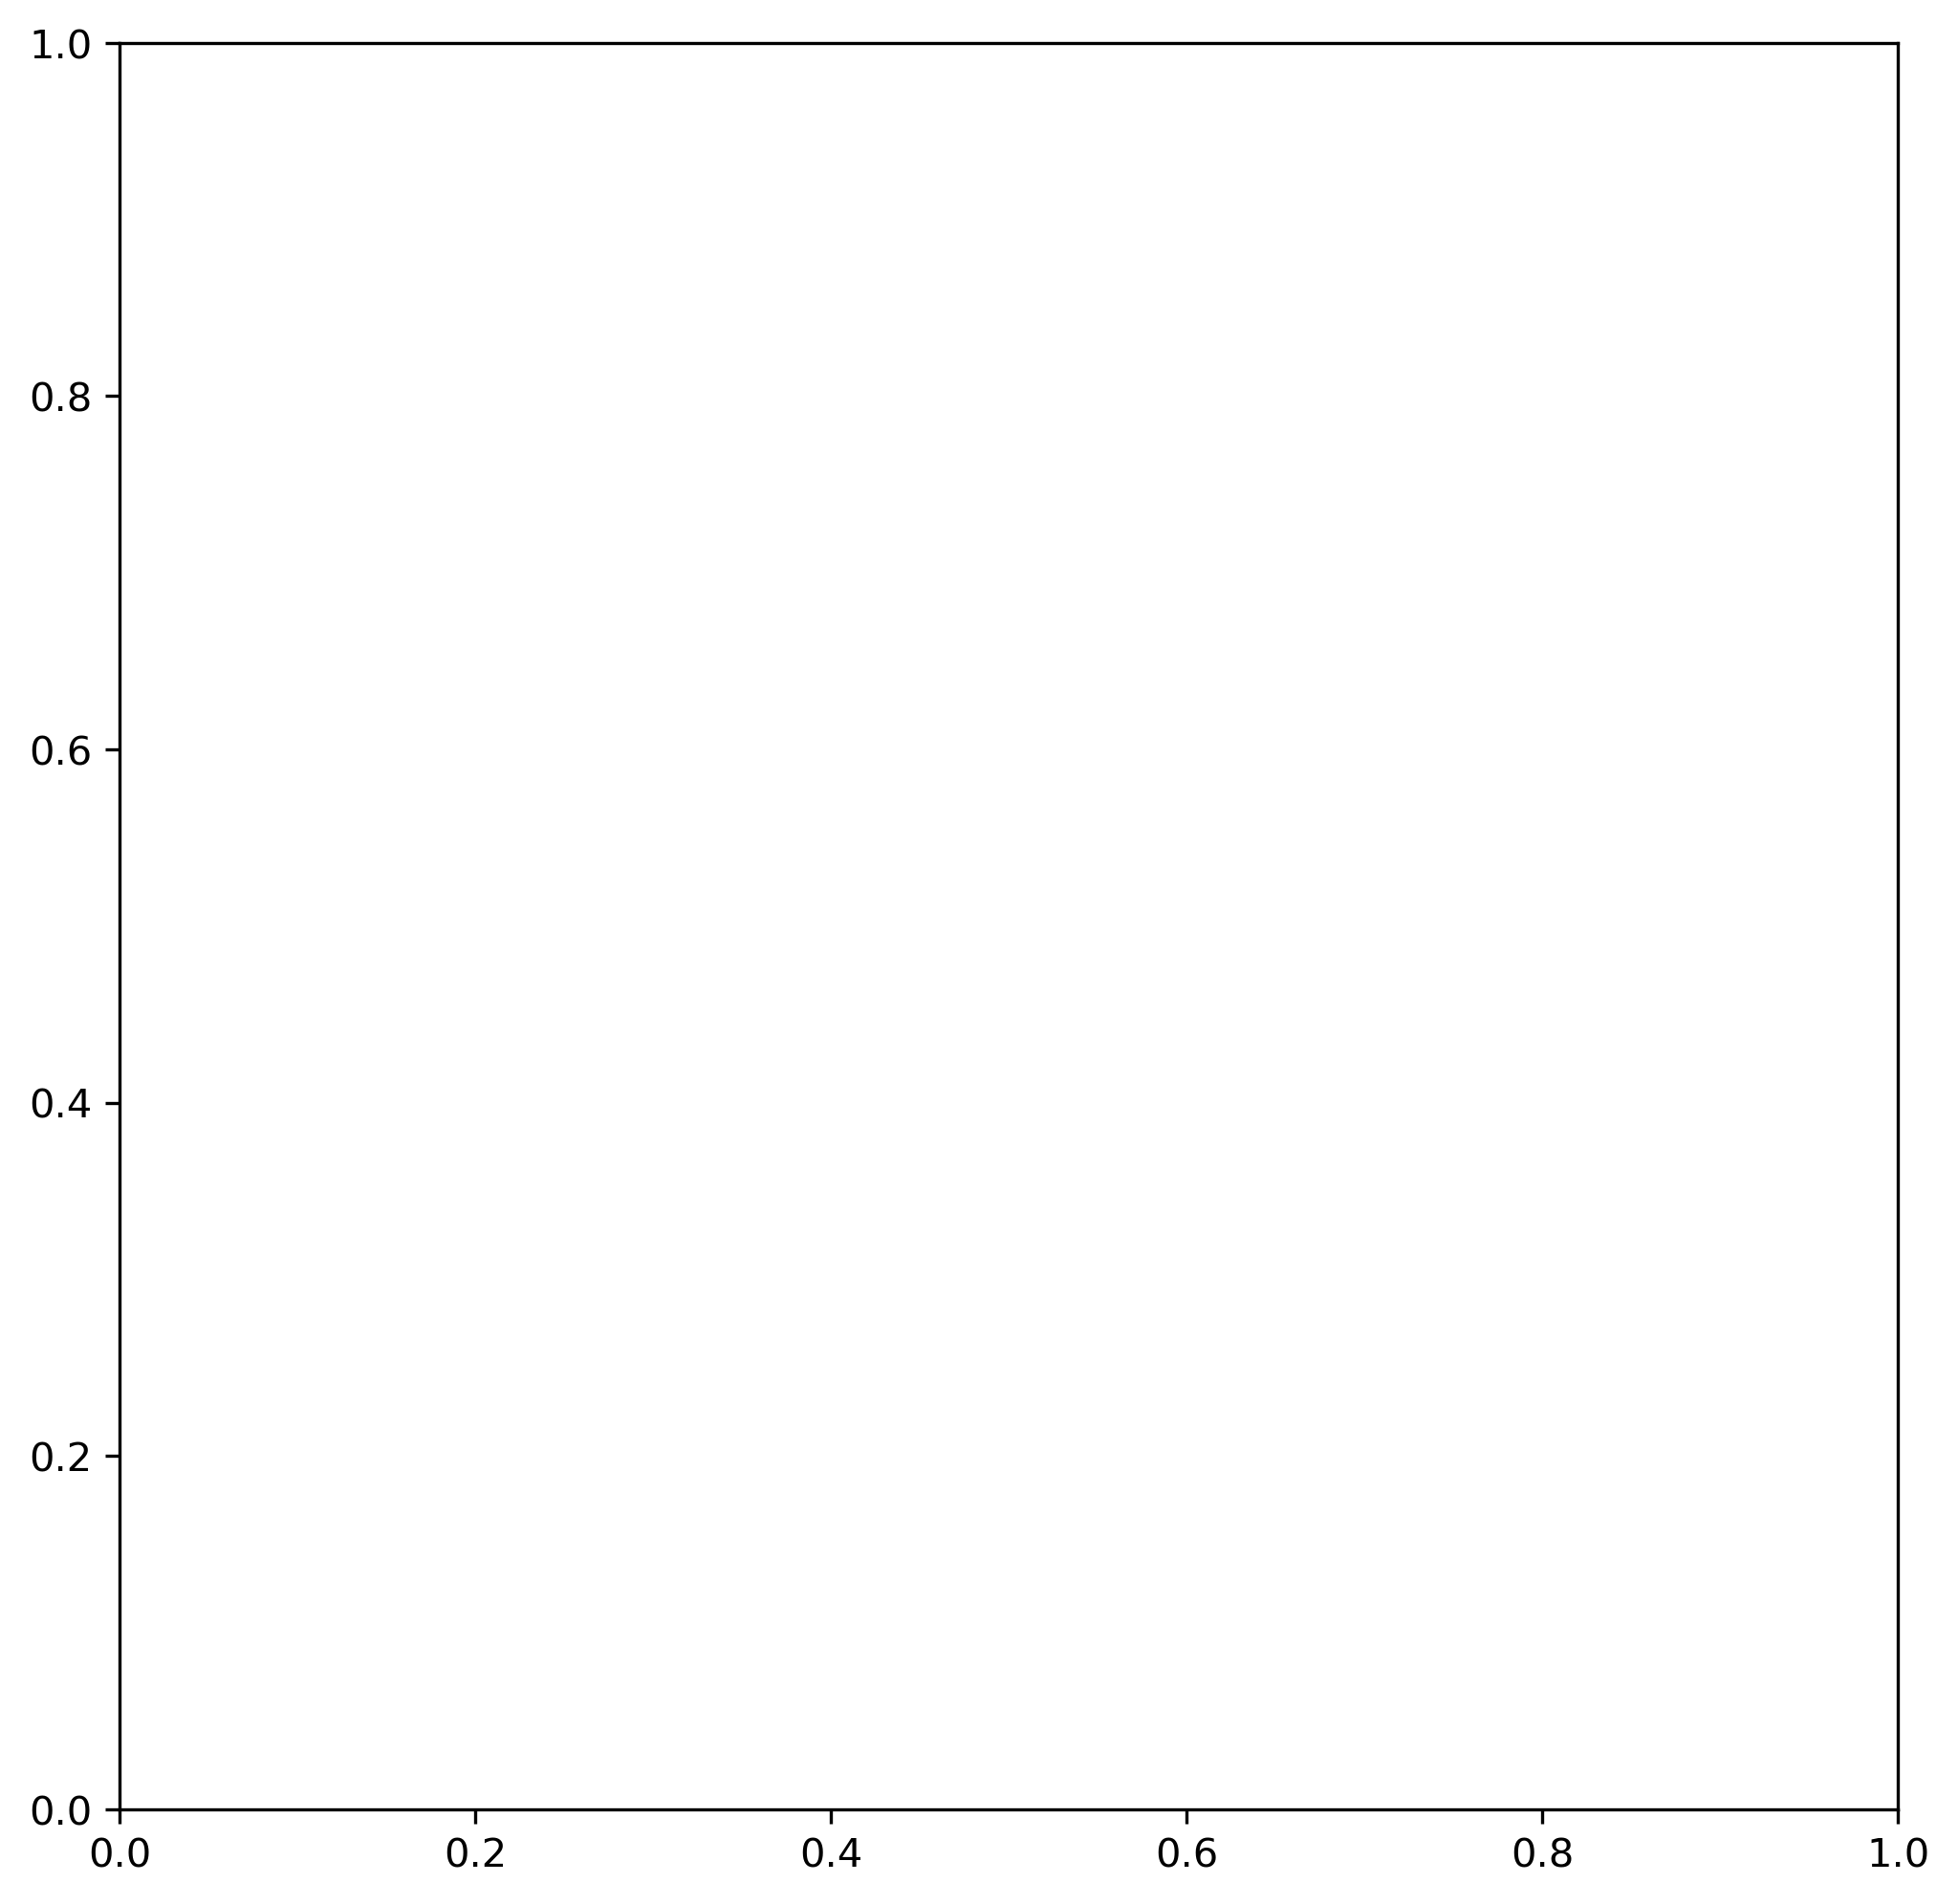

In [128]:
rv_plot(model,data,targ_rv,mjds)